# Двухуровневая модель рекомендаций

**Основное**
-
- Целевая метрика precision@5
- Бейзлайн решения - [MainRecommender](https://github.com/geangohn/recsys-tutorial/blob/master/src/recommenders.py)
- Сдаем ссылку на github с решением. В решении должны быть отчетливо видна метрика на новом тестовом сете из файла retail_test1.csv, то есть вам нужно для всех юзеров из этого файла выдать выши рекомендации, и посчитать на actual покупках precision@5. 

**!! Мы не рассматриваем холодный старт для пользователя, все наши пользователя одинаковы во всех сетах, поэтому нужно позаботиться об их исключении из теста.**


**Hints:** 

Сначала просто попробуйте разные параметры MainRecommender:  
- N в топ-N товарах при формировании user-item матирцы (сейчас топ-5000)  
- Различные веса в user-item матрице (0/1, кол-во покупок, log(кол-во покупок + 1), сумма покупки, ...)  
- Разные взвешивания матрицы (TF-IDF, BM25 - у него есть параметры)  
- Разные смешивания рекомендаций (обратите внимание на бейзлайн - прошлые покупки юзера)  

Сделайте MVP - минимально рабочий продукт - (пусть даже top-popular), а потом его улучшайте

Если вы делаете двухуровневую модель - следите за валидацией 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
import lightgbm
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [2]:
%load_ext autoreload

In [3]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 9 недель -- | -- 3 недели (отложенный тест) -- 

val_lvl_1_size_weeks = 9
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
# data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.tail(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2025344,546,40374217632,572,9337142,2,2.30,327,0.00,1931,82,0.0,0.0
2025345,546,40374217632,572,9526666,1,0.88,327,-0.12,1931,82,0.0,0.0


In [4]:
test1_data = pd.read_csv('retail_test1.csv')

In [5]:
%autoreload
from src.utils import prefilter_items

n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=7000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 82059 to 7001


In [6]:
%autoreload
from src.metrics import precision_at_k, recall_at_k
#from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [7]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/7001 [00:00<?, ?it/s]

### Сгенерируем кандидатов на 1ом уровне


In [8]:
actual_items_lvl_2=data_train_lvl_2[['user_id', 'item_id']]
actual_items_lvl_2=actual_items_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
actual_items_lvl_2.rename(columns={'item_id': 'actual_items'}, inplace=True)
actual_items_lvl_2.head(2)

,user_id,actual_items
0,1,"[836548, 856942, 877391, 933913, 948420, 10368..."
1,2,"[831125, 838136, 852864, 899624, 908649, 91504..."


In [9]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']


train_users = data_train_lvl_1['user_id'].unique()
#users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

In [10]:
users_lvl_2[~users_lvl_2['user_id'].isin(train_users)].count()

user_id    3
dtype: int64

In [11]:
recall_list=[]
recall_at_k_list=[]

#K=[20, 50, 100, 200, 500]
K=[700]

for k in K:
    users_lvl_2_final=users_lvl_2.copy()
    users_lvl_2_final['candidates'] = users_lvl_2_final['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=k))
    act_and_rec_df_lvl_2=actual_items_lvl_2.merge(users_lvl_2_final, on='user_id', how='left')
    act_and_rec_df_lvl_2.head(2)

    for i in range(len(act_and_rec_df_lvl_2['user_id'])):
        recall_list.append(recall_at_k(act_and_rec_df_lvl_2['candidates'][i], act_and_rec_df_lvl_2['actual_items'][i], k=k))
    mean_recall_at_k_1st=np.mean(recall_list)
    print("Качество recall_at_k для k=",k, 'равно:',mean_recall_at_k_1st)
    recall_at_k_list.append(mean_recall_at_k_1st)


Качество recall_at_k для k= 700 равно: 0.20115691614497822


In [12]:
first_level_candidates=users_lvl_2_final

In [13]:
first_level_candidates.head()

,user_id,candidates
0,790,"[9297055, 9297310, 9297032, 7410320, 1100273, ..."
1,1795,"[9655482, 990297, 8181555, 1060318, 835247, 12..."
2,2244,"[1108131, 1083787, 7142552, 9297106, 12452939,..."
3,84,"[903529, 868131, 987518, 829722, 953464, 90106..."
4,1116,"[8118618, 851241, 820612, 853210, 1084342, 106..."


In [14]:
s = users_lvl_2_final.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

In [15]:
users_lvl_2_final = users_lvl_2_final.drop('candidates', axis=1).join(s)
users_lvl_2_final['flag'] = 1

In [16]:
users_lvl_2_final.head(2)

,user_id,item_id,flag
0,790,9297055,1
0,790,9297310,1


In [17]:
users_lvl_2_final.shape[0]

1580600

In [18]:
users_lvl_2_final['user_id'].nunique()

2258

### Обучим модель 2-ого уровня

In [19]:
data_train_lvl_2.tail(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2282323,462,41297773713,635,10180324,1,3.00,304,-0.29,2040,91,0.0,0.0
2282324,462,41297773713,635,12731714,1,4.08,304,0.00,2040,91,0.0,0.0


In [20]:
%autoreload
import src.prepare_dataset as prepare_dataset

In [21]:
data_train_lvl_2=prepare_dataset.add_user_items_features(data_train_lvl_2, item_features, user_features)

In [22]:
user_average_bill=prepare_dataset.user_average_bill(data_train_lvl_2) 
overall_average_bill=prepare_dataset.overall_average_bill(user_average_bill) 
user_item_quantity=prepare_dataset.user_item_quantity(data_train_lvl_2) 
overall_average_item_quantity=prepare_dataset.overall_average_item_quantity(user_item_quantity)
user_item_frequency=prepare_dataset.user_item_frequency(data_train_lvl_2) 
overall_item_frequency=prepare_dataset.overall_item_frequency(user_item_frequency) 
user_total_quantity=prepare_dataset.user_total_quantity(data_train_lvl_2) 
avr_total_quantity=prepare_dataset.avr_total_quantity(user_total_quantity) 
user_comodity_popularity=prepare_dataset.user_comodity_popularity(data_train_lvl_2)
overall_comodity_popularity=prepare_dataset.overall_comodity_popularity(user_comodity_popularity)
hh_comp_comodity_popularity=prepare_dataset.hh_comp_comodity_popularity(data_train_lvl_2)

In [23]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [24]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [25]:
data_train_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,790,40341753006,573,1110624,1,3.59,31782,0.00,19,83,...,FRZN BREAKFAST FOODS,FRZN BREAKFAST ENTREES/SANDWIC,11 OZ,45-54,U,50-74K,Homeowner,Unknown,1,None/Unknown
1,790,40341753006,573,5570406,1,1.67,31782,-1.92,19,83,...,FRZN MEAT/MEAT DINNERS,FRZN SS PREMIUM ENTREES/DNRS/T,14.0 OZ,45-54,U,50-74K,Homeowner,Unknown,1,None/Unknown


In [26]:
data_train_lvl_2.columns

Index(['user_id', 'basket_id', 'day', 'item_id', 'quantity', 'sales_value',
       'store_id', 'retail_disc', 'trans_time', 'week_no', 'coupon_disc',
       'coupon_match_disc', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc'],
      dtype='object')

In [27]:
targets_lvl_2=prepare_dataset.add_part1_features(data_train_lvl_2, users_lvl_2_final, item_features, user_features, user_average_bill, overall_average_bill, overall_average_item_quantity, user_item_quantity,
                      overall_item_frequency,user_item_frequency, user_total_quantity, avr_total_quantity)

In [28]:
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_average_bill,user_item_quantity,overall_item_frequency,item_frequency,user_total_quantity,user_log_quantity
0,790,9297055,0.0,274,GROCERY,National,FRZN BREAKFAST FOODS,FRZN BREAKFAST ENTREES/SANDWIC,8.8 OZ,45-54,...,Homeowner,Unknown,1,None/Unknown,3.220757,1.125,0.009626,0.009626,176,0.753772
1,790,9297310,1.0,274,GROCERY,National,FRZN BREAKFAST FOODS,FRZN BREAKFAST ENTREES/SANDWIC,9.4 OZ,45-54,...,Homeowner,Unknown,1,None/Unknown,3.220757,1.000,0.005884,0.005682,176,0.693147


In [29]:
targets_lvl_2['target'].mean()

0.05103080447194776

In [30]:
targets_lvl_2=prepare_dataset.add_part2_features(targets_lvl_2, overall_comodity_popularity, user_comodity_popularity)

In [31]:
targets_lvl_2=prepare_dataset.targets_fillblanks(targets_lvl_2, hh_comp_comodity_popularity)

In [32]:
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,user_average_bill,user_item_quantity,overall_item_frequency,item_frequency,user_total_quantity,user_log_quantity,overall_comodity_popularity,user_comodity_popularity,hh_comp_comodity_popularity,item_norm_quantity
0,790,9297055,0.0,274,GROCERY,National,FRZN BREAKFAST FOODS,FRZN BREAKFAST ENTREES/SANDWIC,8.8 OZ,45-54,...,3.220757,1.125,0.009626,0.009626,176,0.753772,2.640244,22.0,0.046875,0.006392
1,790,9297310,1.0,274,GROCERY,National,FRZN BREAKFAST FOODS,FRZN BREAKFAST ENTREES/SANDWIC,9.4 OZ,45-54,...,3.220757,1.000,0.005884,0.005682,176,0.693147,2.640244,22.0,0.046875,0.005682


In [33]:
data_train_lvl_2.to_csv('data_train_lvl_2.csv')

In [34]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [35]:
X_train.columns

Index(['user_id', 'item_id', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc',
       'user_average_bill', 'user_item_quantity', 'overall_item_frequency',
       'item_frequency', 'user_total_quantity', 'user_log_quantity',
       'overall_comodity_popularity', 'user_comodity_popularity',
       'hh_comp_comodity_popularity', 'item_norm_quantity'],
      dtype='object')

In [36]:
#cat_feats = X_train.columns[2:].tolist()
#cat_feats = X_train.columns[:-6].tolist()
cat_feats = X_train.columns.tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['user_id',
 'item_id',
 'manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'user_average_bill',
 'user_item_quantity',
 'overall_item_frequency',
 'item_frequency',
 'user_total_quantity',
 'user_log_quantity',
 'overall_comodity_popularity',
 'user_comodity_popularity',
 'hh_comp_comodity_popularity',
 'item_norm_quantity']

In [37]:
X_train.columns

Index(['user_id', 'item_id', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc',
       'user_average_bill', 'user_item_quantity', 'overall_item_frequency',
       'item_frequency', 'user_total_quantity', 'user_log_quantity',
       'overall_comodity_popularity', 'user_comodity_popularity',
       'hh_comp_comodity_popularity', 'item_norm_quantity'],
      dtype='object')

In [38]:
from sklearn.preprocessing import MinMaxScaler

In [39]:
scaler=MinMaxScaler()

In [40]:
#X_train_scalled=scaler.fit_transform(X_train)

In [41]:
#X_train_scalled

In [42]:
#lgb = LGBMClassifier(objective='binary', max_depth=2, categorical_column=cat_feats, n_estimators=500)
lgb = LGBMClassifier(objective='binary', max_depth=2, n_estimators=400, learning_rate=0.01, n_jobs=4)
lgb.fit(X_train, y_train)

#train_preds = lgb.predict(X_train)

/home/evm/GB/gb_tasks/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/evm/GB/gb_tasks/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(learning_rate=0.01, max_depth=2, n_estimators=400, n_jobs=4,
               objective='binary')

In [43]:
train_pred_proba=lgb.predict_proba(X_train)

In [44]:
# добавим вероятности покупки в датасет

train_pred_proba_df =X_train[['user_id', 'item_id']].copy()
train_pred_proba_df['proba']=train_pred_proba[:,1]

In [45]:
X_train.columns

Index(['user_id', 'item_id', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc',
       'user_average_bill', 'user_item_quantity', 'overall_item_frequency',
       'item_frequency', 'user_total_quantity', 'user_log_quantity',
       'overall_comodity_popularity', 'user_comodity_popularity',
       'hh_comp_comodity_popularity', 'item_norm_quantity'],
      dtype='object')

In [46]:
lgb.feature_importances_

array([ 66, 161,   0,   0,   0,  39,   1,   1,   0,   0,   0,   0,   0,
         0,   0,   0, 313,  50, 229,   0,   0,  51, 261,   0,  28],
      dtype=int32)

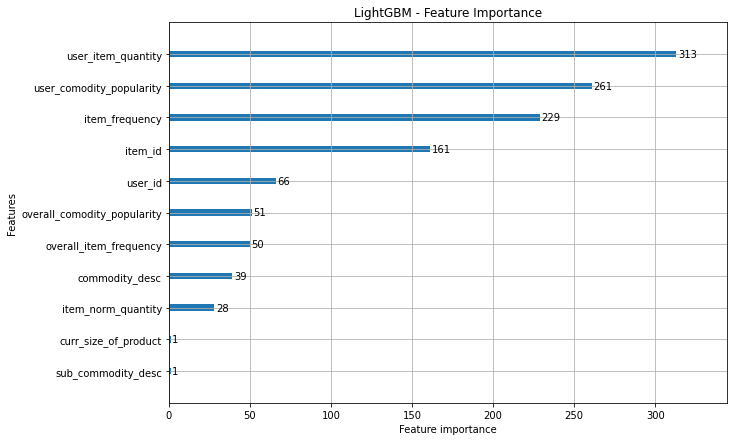

In [47]:
fig, ax = plt.subplots(figsize=(10, 7))
lightgbm.plot_importance(lgb, max_num_features=len(X_train.columns), ax=ax)
plt.title("LightGBM - Feature Importance");

In [48]:
train_pred_proba_df.head(2)

,user_id,item_id,proba
0,790,9297055,0.056803
1,790,9297310,0.650374


In [49]:
# отсортируем датасет по убыванию вероятности покупки
train_pred_proba_df.sort_values('proba', ascending=False, inplace=True)
train_pred_proba_df.head()

,user_id,item_id,proba
390379,294,1082185,0.955387
1045981,334,1082185,0.955387
424386,1297,1082185,0.955387
424385,1297,1082185,0.955387
711328,109,1082185,0.955387


In [50]:
# получим по кажомуму пользователю отсортированные уникальные рекомендации
train_pred_rec=train_pred_proba_df.groupby('user_id')['item_id'].unique().reset_index()
train_pred_rec.head()

,user_id,item_id
0,1,"[1082185, 979707, 940947, 865456, 856942, ...,..."
1,2,"[916122, 899624, 1082185, 979707, 1106523, ......"
2,3,"[946839, 1135622, 9676866, 5570882, 965267, ....."
3,4,"[883932, 990797, 1052294, 908283, 8118675, ......"
4,5,"[6463482, 1036106, 965267, 1023720, 930118, ....."


In [51]:
actual_items=data_train_lvl_2[['user_id', 'item_id']]
actual_items=actual_items.groupby('user_id')['item_id'].unique().reset_index()
actual_items.rename(columns={'item_id': 'actual_items'}, inplace=True)
actual_items.head(2)

,user_id,actual_items
0,1,"[836548, 856942, 877391, 933913, 948420, 10368..."
1,2,"[831125, 838136, 852864, 899624, 908649, 91504..."


In [52]:
act_and_rec_df_lvl_2=actual_items.merge(train_pred_rec, on='user_id', how='left')
act_and_rec_df_lvl_2.head(2)

,user_id,actual_items,item_id
0,1,"[836548, 856942, 877391, 933913, 948420, 10368...","[1082185, 979707, 940947, 865456, 856942, ...,..."
1,2,"[831125, 838136, 852864, 899624, 908649, 91504...","[916122, 899624, 1082185, 979707, 1106523, ......"


In [53]:
l=[]
for i in range(len(act_and_rec_df_lvl_2['user_id'])):
    l.append(precision_at_k(act_and_rec_df_lvl_2['item_id'][i], act_and_rec_df_lvl_2['actual_items'][i], k=5))
mean_precision_at_k=np.mean(l)
print("Качество precision_at_k на трейне", mean_precision_at_k)

Качество precision_at_k на трейне 0.8018600531443755


Посмотрим качество на 3м уровне

In [54]:
test_users = pd.DataFrame(test1_data['user_id'].unique())
test_users.columns = ['user_id']

In [55]:
test_users.shape

(1885, 1)

In [56]:
train_users = first_level_candidates['user_id'].unique()
test_missing_users=test_users[~test_users['user_id'].isin(train_users)]
test_missing_users.shape

(66, 1)

In [57]:
test_missing_users['candidates'] = test_missing_users['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=800))

<ipython-input-57-9b6800da55a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_missing_users['candidates'] = test_missing_users['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=800))


In [58]:
users_lvl_3_final=test_users.merge(first_level_candidates, on='user_id', how='inner')
users_lvl_3_final.head(2)

,user_id,candidates
0,1340,"[13381928, 1024032, 7147133, 948381, 1069582, ..."
1,588,"[1100830, 1097363, 983659, 7410336, 896611, 10..."


In [59]:
users_lvl_3_final.shape

(1819, 2)

In [60]:
users_lvl_3=pd.concat([users_lvl_3_final,test_missing_users])
test_1st_level_pred=users_lvl_3

In [61]:
users_lvl_3.shape

(1885, 2)

In [62]:
s2 = users_lvl_3.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s2.name = 'item_id'

In [63]:
users_lvl_3 = users_lvl_3.drop('candidates', axis=1).join(s2)
users_lvl_3['flag'] = 1

users_lvl_3.head(5)

,user_id,item_id,flag
0,1340,13381928.0,1
0,1340,1024032.0,1
0,1340,7147133.0,1
0,1340,948381.0,1
0,1340,1069582.0,1


In [64]:
users_lvl_3['item_id']=users_lvl_3['item_id'].astype('int')


In [65]:
targets_lvl_3=prepare_dataset.add_part1_features(test1_data, users_lvl_3, item_features, user_features,user_average_bill, overall_average_bill, overall_average_item_quantity, user_item_quantity,
                      overall_item_frequency,user_item_frequency, user_total_quantity, avr_total_quantity)

In [66]:
targets_lvl_3=prepare_dataset.add_part2_features(targets_lvl_3, overall_comodity_popularity, user_comodity_popularity)

In [67]:
targets_lvl_3=prepare_dataset.targets_fillblanks(targets_lvl_3, hh_comp_comodity_popularity)

In [68]:
targets_lvl_3.head(2)




,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,user_average_bill,user_item_quantity,overall_item_frequency,item_frequency,user_total_quantity,user_log_quantity,overall_comodity_popularity,user_comodity_popularity,hh_comp_comodity_popularity,item_norm_quantity
0,1340,13381928,0.0,239,GROCERY,National,BEERS/ALES,BEERALEMALT LIQUORS,12/12 OZ,45-54,...,1.821875,1.0,0.003349,0.003349,8.0,0.693147,3.292948,3.292948,0.146532,0.125
1,1340,1024032,0.0,69,GROCERY,Private,CHEESE,NATURAL CHEESE EXACT WT CHUNKS,24 OZ,45-54,...,1.821875,1.0,0.007453,0.007453,8.0,0.693147,2.539409,2.539409,0.159138,0.125


In [69]:
targets_lvl_3['target'].mean()

0.019688725265906898

In [70]:
X_test = targets_lvl_3.drop('target', axis=1)
y_test = targets_lvl_3[['target']]

In [71]:
X_test.head(2)

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,...,user_average_bill,user_item_quantity,overall_item_frequency,item_frequency,user_total_quantity,user_log_quantity,overall_comodity_popularity,user_comodity_popularity,hh_comp_comodity_popularity,item_norm_quantity
0,1340,13381928,239,GROCERY,National,BEERS/ALES,BEERALEMALT LIQUORS,12/12 OZ,45-54,U,...,1.821875,1.0,0.003349,0.003349,8.0,0.693147,3.292948,3.292948,0.146532,0.125
1,1340,1024032,69,GROCERY,Private,CHEESE,NATURAL CHEESE EXACT WT CHUNKS,24 OZ,45-54,U,...,1.821875,1.0,0.007453,0.007453,8.0,0.693147,2.539409,2.539409,0.159138,0.125


In [72]:
#X_test=X_test.drop(cat_feats, axis=1)

In [73]:
X_test.columns

Index(['user_id', 'item_id', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
       'age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc',
       'user_average_bill', 'user_item_quantity', 'overall_item_frequency',
       'item_frequency', 'user_total_quantity', 'user_log_quantity',
       'overall_comodity_popularity', 'user_comodity_popularity',
       'hh_comp_comodity_popularity', 'item_norm_quantity'],
      dtype='object')

In [74]:
X_test[cat_feats] = X_test[cat_feats].astype('category')

cat_feats

['user_id',
 'item_id',
 'manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'user_average_bill',
 'user_item_quantity',
 'overall_item_frequency',
 'item_frequency',
 'user_total_quantity',
 'user_log_quantity',
 'overall_comodity_popularity',
 'user_comodity_popularity',
 'hh_comp_comodity_popularity',
 'item_norm_quantity']

In [75]:
#X_test_scalled=scaler.fit_transform(X_test)

In [76]:
test_pred_proba=lgb.predict_proba(X_test)

# добавим вероятности покупки в датасет

test_pred_proba_df =X_test[['user_id', 'item_id']].copy()
test_pred_proba_df['proba']=test_pred_proba[:,1]

# отсортируем датасет по убыванию вероятности покупки
test_pred_proba_df.sort_values('proba', ascending=False, inplace=True)
test_pred_proba_df.head()

,user_id,item_id,proba
4794,1762,1082185,0.955387
921128,427,1082185,0.955387
285153,2312,1082185,0.955387
3801,117,1082185,0.955387
285152,2312,1082185,0.955387


In [77]:
# получим по кажомуму пользователю отсортированные уникальные рекомендации
test_pred_rec=test_pred_proba_df.groupby('user_id')['item_id'].unique().reset_index()
test_pred_rec.head()

,user_id,item_id
0,1,"[1082185, 979707, 940947, 865456, 856942, ...,..."
1,2,"[916122, 899624, 1082185, 979707, 1106523, ......"
2,3,"[946839, 1135622, 9676866, 5570882, 965267, ....."
3,6,"[1082185, 1098844, 1105488, 6548453, 845208, ...."
4,7,"[1082185, 1106523, 1126899, 909714, 825994, ....."


In [78]:
test_actual_items=test1_data[['user_id', 'item_id']]
test_actual_items=test_actual_items.groupby('user_id')['item_id'].unique().reset_index()
test_actual_items.rename(columns={'item_id': 'actual_items'}, inplace=True)
test_actual_items.head(2)

,user_id,actual_items
0,1,"[880007, 883616, 931136, 938004, 940947, 94726..."
1,2,"[820165, 820291, 826784, 826835, 829009, 85784..."


In [79]:
act_and_rec_df_lvl_3=test_actual_items.merge(test_pred_rec, on='user_id', how='left')
act_and_rec_df_lvl_3.head(2)

,user_id,actual_items,item_id
0,1,"[880007, 883616, 931136, 938004, 940947, 94726...","[1082185, 979707, 940947, 865456, 856942, ...,..."
1,2,"[820165, 820291, 826784, 826835, 829009, 85784...","[916122, 899624, 1082185, 979707, 1106523, ......"


In [80]:
act_and_rec_df_lvl_3=act_and_rec_df_lvl_3.merge(test_1st_level_pred, on='user_id', how='left')
act_and_rec_df_lvl_3.head(2)

,user_id,actual_items,item_id,candidates
0,1,"[880007, 883616, 931136, 938004, 940947, 94726...","[1082185, 979707, 940947, 865456, 856942, ...,...","[856942, 5577022, 9297615, 1124029, 1087895, 1..."
1,2,"[820165, 820291, 826784, 826835, 829009, 85784...","[916122, 899624, 1082185, 979707, 1106523, ......","[978332, 244960, 7433029, 970481, 9365106, 644..."


In [81]:
l_1st_level_recall=[]
l_1st_level=[]
l_2nd_level=[]
for i in range(len(act_and_rec_df_lvl_3['user_id'])):
    l_1st_level_recall.append(recall_at_k(act_and_rec_df_lvl_3['candidates'][i], act_and_rec_df_lvl_3['actual_items'][i], k=len(act_and_rec_df_lvl_3['candidates'])))
    l_1st_level.append(precision_at_k(act_and_rec_df_lvl_3['candidates'][i], act_and_rec_df_lvl_3['actual_items'][i], k=5))
    l_2nd_level.append(precision_at_k(act_and_rec_df_lvl_3['item_id'][i], act_and_rec_df_lvl_3['actual_items'][i], k=5))
test_mean_rcall_at_N_1st=np.mean(l_1st_level_recall)
test_mean_precision_at_k_1st=np.mean(l_1st_level)
test_mean_precision_at_k_2nd=np.mean(l_2nd_level)
print("Качество recall_at_N на тесте после простой модели", test_mean_rcall_at_N_1st)
print("Качество precision_at_k на тесте после простой модели", test_mean_precision_at_k_1st)
print("Качество precision_at_k на тесте после LightGBM", test_mean_precision_at_k_2nd)

Качество recall_at_N на тесте после простой модели 0.21298220803933784
Качество precision_at_k на тесте после простой модели 0.14376657824933686
Качество precision_at_k на тесте после LightGBM 0.23151193633952258


In [82]:
all_users = pd.DataFrame(data['user_id'].unique())
all_users.columns = ['user_id']
all_missing_users=all_users[~all_users['user_id'].isin(train_users)]
all_missing_users['candidates'] = all_missing_users['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=800))
all_users_final=all_users.merge(first_level_candidates, on='user_id', how='inner')
test_all_users=pd.concat([all_users_final,test_missing_users])
test_all_users_pred=test_all_users


<ipython-input-82-f831a36e4684>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_missing_users['candidates'] = all_missing_users['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=800))


In [83]:
s3 = test_all_users.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s3.name = 'item_id'
test_all_users = test_all_users.drop('candidates', axis=1).join(s3)
test_all_users['flag'] = 1
test_all_users['item_id']=test_all_users['item_id'].astype('int')

In [84]:
targets_all_users=prepare_dataset.add_part1_features(data, test_all_users, item_features, user_features,user_average_bill, overall_average_bill, overall_average_item_quantity, user_item_quantity,
                      overall_item_frequency,user_item_frequency, user_total_quantity, avr_total_quantity)
targets_all_users=prepare_dataset.add_part2_features(targets_all_users, overall_comodity_popularity, user_comodity_popularity)
targets_all_users=prepare_dataset.targets_fillblanks(targets_all_users, hh_comp_comodity_popularity)

In [85]:
X_test_all = targets_all_users.drop('target', axis=1)
y_test_all = targets_all_users[['target']]
X_test_all[cat_feats] = X_test_all[cat_feats].astype('category')

all_pred_proba=lgb.predict_proba(X_test_all)

# добавим вероятности покупки в датасет

all_pred_proba_df =X_test_all[['user_id', 'item_id']].copy()
all_pred_proba_df['proba']=all_pred_proba[:,1]

# отсортируем датасет по убыванию вероятности покупки
all_pred_proba_df.sort_values('proba', ascending=False, inplace=True)
all_pred_proba_df.head()

# получим по кажомуму пользователю отсортированные уникальные рекомендации
all_pred_rec=all_pred_proba_df.groupby('user_id')['item_id'].unique().reset_index()
all_pred_rec.head()

,user_id,item_id
0,1,"[1082185, 979707, 940947, 865456, 856942, ...,..."
1,2,"[916122, 899624, 1082185, 979707, 1106523, ......"
2,3,"[946839, 1135622, 9676866, 5570882, 965267, ....."
3,4,"[883932, 990797, 1052294, 908283, 838571, ...,..."
4,5,"[6463482, 1036106, 965267, 930118, 1023720, ....."


In [86]:
all_pred_rec.shape

(2324, 2)

In [87]:
for user in range(len(all_pred_rec['user_id'])):
    all_pred_rec['item_id'][user]=np.array(all_pred_rec['item_id'][user][:5])
    

<ipython-input-87-3ba8328ac54f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_pred_rec['item_id'][user]=np.array(all_pred_rec['item_id'][user][:5])


In [88]:
all_pred_rec.head()

,user_id,item_id
0,1,"[1082185, 979707, 940947, 865456, 856942]"
1,2,"[916122, 899624, 1082185, 979707, 1106523]"
2,3,"[946839, 1135622, 9676866, 5570882, 965267]"
3,4,"[883932, 990797, 1052294, 908283, 838571]"
4,5,"[6463482, 1036106, 965267, 930118, 1023720]"


In [89]:
all_pred_rec.to_csv('Mikhachev_pred_rec.csv', index=False)